In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

     |████████████████████████████████| 274 kB 14.1 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=95a1ae480b570a1e943c527591e1d2ef749c7f36451ff0a5d1144cf97acd4a0e
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 8.9 MB/s 
     |████████████████████████████████| 74 kB 3.8 MB/s 
     |████████████████████████████████| 145 kB 34.2 MB/s 
     |████████████████████████████████| 130 kB 77.9 MB/s 
     |████████████████████████████████| 49 kB 7.5 MB/s 
     |████████████████████████████████| 749 kB 69.9 MB/s 
     |██████████████████████████████

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
!nvidia-smi

Tue Jan 11 19:44:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("data_train", {}, "/content/drive/MyDrive/#Project/chicken_detection/train.json", "/content/drive/MyDrive/#Project/chicken_detection/train")
register_coco_instances("data_test", {}, "/content/drive/MyDrive/#Project/chicken_detection/test.json", "/content/drive/MyDrive/#Project/chicken_detection/test")
register_coco_instances("data_valid", {}, "/content/drive/MyDrive/#Project/chicken_detection/valid.json", "/content/drive/MyDrive/#Project/chicken_detection/valid")

In [5]:
data_train_metadata = MetadataCatalog.get("data_train")
train_dicts = DatasetCatalog.get("data_train")

WARNING [01/11 19:46:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/11 19:46:06 d2.data.datasets.coco]: Loaded 417 images in COCO format from /content/drive/MyDrive/#Project/chicken_detection/train.json


In [6]:
data_test_metadata = MetadataCatalog.get("data_test")
test_dicts = DatasetCatalog.get("data_test")

WARNING [01/11 19:46:07 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/11 19:46:07 d2.data.datasets.coco]: Loaded 10 images in COCO format from /content/drive/MyDrive/#Project/chicken_detection/test.json


In [7]:
data_valid_metadata = MetadataCatalog.get("data_valid")
valid_dicts = DatasetCatalog.get("data_valid")

WARNING [01/11 19:46:08 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/11 19:46:08 d2.data.datasets.coco]: Loaded 36 images in COCO format from /content/drive/MyDrive/#Project/chicken_detection/valid.json


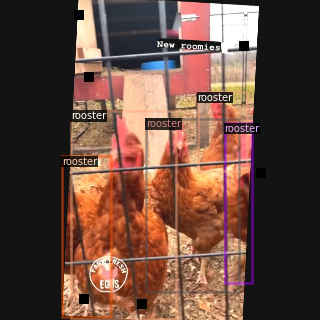

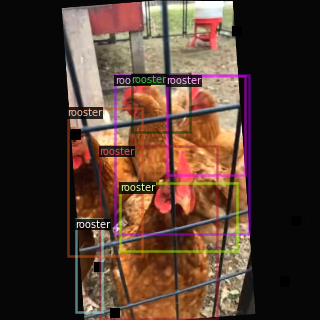

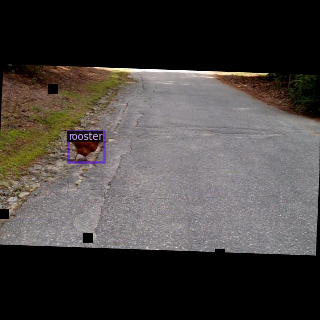

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(train_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=data_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("data_train",)
cfg.DATASETS.TEST = ("data_valid")

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2

cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 3000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []         # do not decay learning rate

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 640   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.OUTPUT_DIR = "/content/drive/MyDrive/#Project/chicken_detection/model"

trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/11 10:57:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[01/11 10:57:21 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/11 10:57:36 d2.utils.events]:  eta: 0:34:57  iter: 19  total_loss: 1.601  loss_cls: 1.283  loss_box_reg: 0.3209  loss_rpn_cls: 0.006036  loss_rpn_loc: 0.017  time: 0.6957  data_time: 0.0312  lr: 4.9953e-06  max_mem: 4637M
[01/11 10:57:50 d2.utils.events]:  eta: 0:36:04  iter: 39  total_loss: 1.443  loss_cls: 1.154  loss_box_reg: 0.2514  loss_rpn_cls: 0.003057  loss_rpn_loc: 0.01386  time: 0.7046  data_time: 0.0053  lr: 9.9902e-06  max_mem: 4637M
[01/11 10:58:04 d2.utils.events]:  eta: 0:34:28  iter: 59  total_loss: 1.238  loss_cls: 0.8846  loss_box_reg: 0.2976  loss_rpn_cls: 0.01494  loss_rpn_loc: 0.01368  time: 0.6983  data_time: 0.0050  lr: 1.4985e-05  max_mem: 4637M
[01/11 10:58:18 d2.utils.events]:  eta: 0:34:24  iter: 79  total_loss: 0.9439  loss_cls: 0.6264  loss_box_reg: 0.2987  loss_rpn_cls: 0.01612  loss_rpn_loc: 0.01511  time: 0.7018  data_time: 0.0050  lr: 1.998e-05  max_mem: 4637M
[01/11 10:58:33 d2.utils.events]:  eta: 0:35:09  iter: 99  total_loss: 0.7963  loss_cls: 0

KeyError: ignored

In [ ]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("data_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "data_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [01/11 11:34:04 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [01/11 11:34:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/11 11:34:04 d2.data.datasets.coco]: Loaded 10 images in COCO format from /content/drive/MyDrive/#Project/chicken_detection/test.json
[01/11 11:34:04 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|  chicken   | 0            |  rooster   | 37           |
|            |              |            |              |
|   total    | 37           |            |              |
[01/11 11:34:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[01/11 11:34:08 d2.evaluation.evaluator]: Total inference time: 0:00:01.402925 (0.280585 s / iter per device, on 1 devices)
[01/11 11:34:08 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.264523 s / iter per device, on 1 devices)
[01/11 11:34:08 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/11 11:34:08 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[01/11 11:34:08 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[01/11 11:34:08 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[01/11 11:34:08 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.00 seconds.
[01/11 11:34:08 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[01/11 11:34:08 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.00 seconds.
 Average Precision  (AP)

OrderedDict([('bbox',
              {'AP': 51.43275725336722,
               'AP-chicken': nan,
               'AP-rooster': 51.43275725336722,
               'AP50': 86.95898161244695,
               'AP75': 67.97186861543297,
               'APl': 55.9808218736862,
               'APm': 24.334158415841582,
               'APs': nan})])

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("data_train",)
cfg.DATASETS.TEST = ("data_valid")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/#Project/chicken_detection/model/model_final.pth"  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

predictor = DefaultPredictor(cfg)

In [9]:
# Save config to file
with open("/content/drive/MyDrive/#Project/chicken_detection/model/config.yaml", "w") as f:
    f.write(cfg.dump())


In [ ]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = DatasetCatalog.get("data_valid")
for d in random.sample(dataset_dicts, 20):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=data_train_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


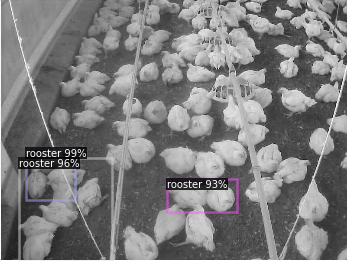

In [ ]:
im = cv2.imread("/content/drive/MyDrive/#Project/chicken_detection/test_data/chicken.jpeg")
outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
    metadata=data_train_metadata, 
    scale=0.5, 
    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
%cd /content/drive/MyDrive/#Project/chicken_detection

# Install dependencies, download the video, and crop 5 seconds for processing
!ffmpeg -i test_data/video2.mp4 -t 00:00:03 -c:v copy test_data/video-clip.mp4

In [ ]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes) with the "demo.py" tool we provided in the repo.
!git clone https://github.com/facebookresearch/detectron2
# Note: this is currently BROKEN due to missing codec. See https://github.com/facebookresearch/detectron2/issues/2901 for workaround.
%run detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

In [10]:
%cd /content/drive/MyDrive/#Project/chicken_detection
!ls

/content/drive/MyDrive/#Project/chicken_detection
chicken_detector.ipynb	test	   train       valid.json
model			test_data  train.json  video.py
predictor.py		test.json  valid


In [37]:
%run video.py --config-file "/content/drive/MyDrive/#Project/chicken_detection/model/config.yaml" \
  --video-input test_data/video3.mp4 --confidence-threshold 0.6 --output video3-output.mp4 \
  --opts MODEL.WEIGHTS "/content/drive/MyDrive/#Project/chicken_detection/model/model_final.pth"

[01/11 20:27:11 detectron2]: Arguments: Namespace(confidence_threshold=0.6, config_file='/content/drive/MyDrive/#Project/chicken_detection/model/config.yaml', input=None, opts=['MODEL.WEIGHTS', '/content/drive/MyDrive/#Project/chicken_detection/model/model_final.pth'], output='video3-output.mp4', video_input='test_data/video3.mp4', webcam=False)
[01/11 20:27:13 fvcore.common.checkpoint]: [Checkpointer] Loading from /content/drive/MyDrive/#Project/chicken_detection/model/model_final.pth ...


  0%|          | 0/381 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
100%|██████████| 381/381 [03:02<00:00,  2.09it/s]


In [ ]:
# Download the results
from google.colab import files
files.download('video-output.mkv')